In [1]:
# import sys
# !{sys.executable} -m pip install seaborn --user

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
saveFigs = True # Saves figures if True

mtu = 1088 # Bytes
ipHdrSize = 20

torBw = 200e9 # bps
linkDelay = 88e-9 # seconds
oneWayDelay = 2 * (mtu*8/torBw + linkDelay)
bdpPkts = 10 # packets

protocols = ['Ndp', 'Homa', 'Homatr']
protocolNames = ['NDP', 'Homa', 'Homa-Tr']
protoNameMap = {}
for protocol in protocols:
    protoNameMap[protocol] = protocolNames[protocols.index(protocol)]
    
# buffSizes = ['74p', '37p']
buffSizes = ['91p', '53p']
buffSizeBytes = {'74p': '76KB', '37p': '38KB', 
                 '91p': '97KB', '53p': '57KB'}

hdrSizes = {'Ndp': 15, 'Homa': 20, 'Homatr': 20}

# folderName = './Buff'
# for buffSize in buffSizes:
#     folderName += '_'+buffSize
# folderName += '/'
folderName = './'

In [4]:
def removeKey(d, key):
    r = dict(d)
    del r[key]
    return r

In [5]:
def calculateMsgSizePkts(msgSize, protocol):
    return msgSize / (mtu - ipHdrSize - hdrSizes[protocol])

# Importing MsgTrace Data

In [6]:
msgTrDfCols = ['protocol','buffSize','msgId','sizePkts','start','finish']
msgTrDfData = {}
for col in msgTrDfCols:
    msgTrDfData[col] = []
    
for protocol in protocols:
    for buffSize in buffSizes:
        
        msgStatTimeHolder = {}
        with open(folderName+protocol+"-Buff"+buffSize+"-MsgTraces.tr",'r') as f:
            for line in f:
                msgLog = line.split()

                time = float(msgLog[1])*1e-9 # in seconds
                msgSize = int(msgLog[2])     # in bytes
                sender = msgLog[3]           # ip:port
                receiver = msgLog[4]         # ip:port

                key = int(receiver.split(':')[1]) # DstPort

                if (msgLog[0]=='+'):
                    msgStatTimeHolder[key] = time

                elif (msgLog[0] =='-'):
                    msgTrDfData['protocol'].append(protocol)
                    msgTrDfData['buffSize'].append(buffSize)
                    msgTrDfData['msgId'].append(key)
                    msgTrDfData['sizePkts'].append(calculateMsgSizePkts(msgSize, protocol))
                    msgTrDfData['start'].append(msgStatTimeHolder[key])
                    msgTrDfData['finish'].append(time)
                    removeKey(msgStatTimeHolder, key)
                    
msgTrDf = pd.DataFrame(data=msgTrDfData)
msgTrDf['mct'] = (msgTrDf.finish - msgTrDf.start)
msgTrDf['ict'] = (msgTrDf.sizePkts - 1) * 8 * mtu / torBw + oneWayDelay
msgTrDf['slowDown'] = msgTrDf.mct / msgTrDf.ict
msgTrDf['buffSize'] = msgTrDf['buffSize'].replace(buffSizeBytes)
msgTrDf['protocol'] = msgTrDf['protocol'].replace(protoNameMap)

In [7]:
# msgTrDf

# Importing Queue Occupancy Data

In [8]:
qlenDfCols = ['protocol','buffSize','time','qLen']
qlenDfData = {}
for col in qlenDfCols:
    qlenDfData[col] = []
    
for protocol in protocols:
    for buffSize in buffSizes:
        
        msgStatTimeHolder = {}
        with open(folderName+protocol+"-Buff"+buffSize+".qlen",'r') as f:
            for line in f:
                msgLog = line.split()

                time = float(msgLog[0])*1e-9 # in seconds
                qlen = int(msgLog[1])     # in bytes
                
                qlenDfData['protocol'].append(protocol)
                qlenDfData['buffSize'].append(buffSize)
                qlenDfData['time'].append(time)
                qlenDfData['qLen'].append(qlen)
                    
qlenDf = pd.DataFrame(data=qlenDfData)
qlenDf['buffSize'] = qlenDf['buffSize'].replace(buffSizeBytes)
qlenDf['protocol'] = qlenDf['protocol'].replace(protoNameMap)

In [9]:
# qlenDf

# Plotting Figures

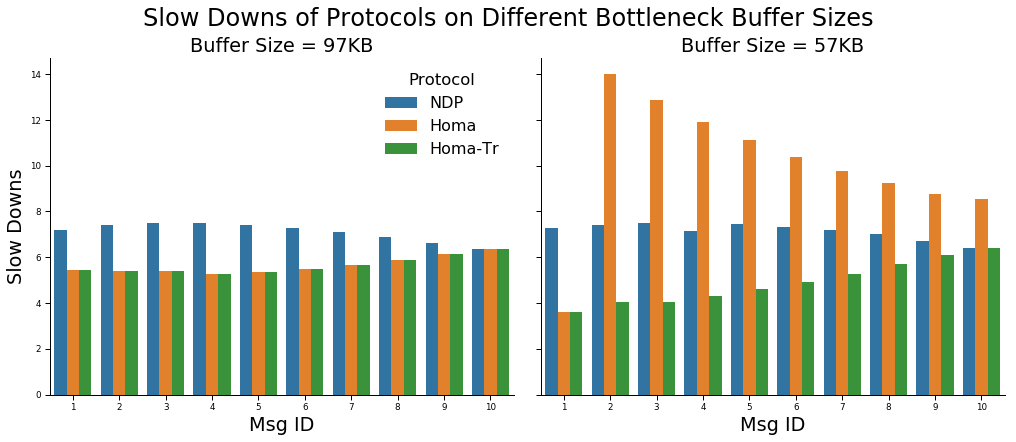

In [10]:
fontsize = 16
sns.set_context("paper", 
                rc={"font.size":fontsize,
                    "axes.titlesize":fontsize*1.5,
                    "axes.labelsize":fontsize*1.2}) 

g = sns.catplot(data = msgTrDf, x = "msgId", y = "slowDown",
                hue = "protocol", hue_order=protocolNames, 
                col = "buffSize", kind = "bar", 
                legend=True, legend_out=False,
                height=6, aspect=1.2)
g.set_axis_labels("Msg ID", "Slow Downs")
g.set_titles('Buffer Size = {col_name}')
g.add_legend(title='Protocol', label_order=protocolNames,
             fontsize=fontsize, frameon=False)
st = plt.suptitle('Slow Downs of Protocols on Different Bottleneck Buffer Sizes',
                  y=1.03, fontsize=fontsize*1.5)
plt.tight_layout()
if (saveFigs):
    plt.savefig(folderName+"NanoPuProtoEval-MsgSlowDowns.png", 
                bbox_extra_artists=[st], bbox_inches='tight')
plt.show()

In [11]:
for (protocol, buffSize), df in msgTrDf.groupby(['protocol','buffSize']):
    print('Slowdown stats for '+protocol+' ('+buffSize+'):')
    print(df.slowDown.describe([0.5,0.9])[['50%','90%']])

Slowdown stats for Homa (57KB):
50%    10.088488
90%    12.981157
Name: slowDown, dtype: float64
Slowdown stats for Homa (97KB):
50%    5.461022
90%    6.166355
Name: slowDown, dtype: float64
Slowdown stats for Homa-Tr (57KB):
50%    4.773408
90%    6.116439
Name: slowDown, dtype: float64
Slowdown stats for Homa-Tr (97KB):
50%    5.461022
90%    6.166355
Name: slowDown, dtype: float64
Slowdown stats for NDP (57KB):
50%    7.248811
90%    7.468449
Name: slowDown, dtype: float64
Slowdown stats for NDP (97KB):
50%    7.236251
90%    7.477794
Name: slowDown, dtype: float64


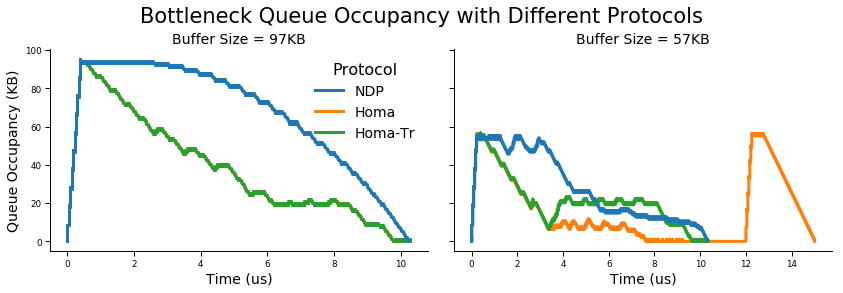

In [12]:
fontsize = 14
fig, ax = plt.subplots(1,len(buffSizes),
                       figsize=(12,4), sharey=True)
i=1
for (buffSize), df in qlenDf.groupby(['buffSize']):
    plt.sca(ax[len(buffSizes)-i])
    for (protocol), dff in df.groupby(['protocol']):
        plt.step((dff.time-dff.time.min())*1e6, dff.qLen/1024, 
                 label=protocol, linewidth=3., where='post',
                 c='C'+str(protocolNames.index(protocol)))
        if (i==len(buffSizes)): 
            plt.ylabel('Queue Occupancy (KB)',fontsize=fontsize)
        plt.xlabel('Time (us)',fontsize=fontsize)
        plt.gca().spines["right"].set_visible(False)
        plt.gca().spines["top"].set_visible(False)
        plt.title('Buffer Size = {}'.format(buffSize), fontsize=fontsize)
    i +=1

handles, labels = plt.gca().get_legend_handles_labels()
order = [labels.index(protocol) for protocol in protocolNames]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
           title='Protocol', fontsize=fontsize, 
           frameon=False, markerscale=2.0)
# plt.grid()
st = plt.suptitle('Bottleneck Queue Occupancy with Different Protocols',
                  y=1.03, fontsize=fontsize*1.5)
plt.tight_layout()
if (saveFigs):
    plt.savefig(folderName+"NanoPuProtoEval-QueueOccupancy.png", 
            bbox_extra_artists=[st], bbox_inches='tight')
plt.show()